# Greybox Fuzzing with Grammars

<!--
Previously, we have learned about [mutational fuzzing](GreyboxFuzzer.ipynb), which generates new inputs by mutating seed inputs. Most mutational fuzzers represent inputs as a sequence of bytes and apply byte-level mutations to this byte sequence. Such byte-level mutations work great for compact file formats with a small number of structural constraints. However, most file formats impose a high-level structure on these byte sequences.

Common components of a regular file are file header, data chunks, checksums, data fields, and meta data. Only if this file structure is correctly reflected will the file be accepted by the parser. Otherwise, the file is quickly rejected before reaching interesting parts in the program. It is not easy to generate valid files by [random fuzzing](Fuzzer.ipynb). For instance, only a tiniest proportion of random strings are valid PDF files or valid JPEG image files.
-->

<!--
Maybe we can start with a valid file and generate new valid files by small mutations applied to the original file? Indeed, this is the main insight of ([blackbox](MutationFuzzer.ipynb) and [greybox](GreyboxFuzzer.ipynb)) mutational fuzzing. However, many file formats are so complex that even small modifications lead to invalid inputs that are quickly rejected by the parser.
-->

In this chapter, we introduce two important extensions to our syntactic fuzzing techniques:

1. We show how to combine [parsing](Parser.ipynb) and [fuzzing](GrammarFuzzer.ipynb) with grammars.  This allows to _mutate_ existing inputs while preserving syntactical correctness, and to _reuse_ fragments from existing inputs while generating new ones.  The combination of parsing and fuzzing, as demonstrated in this chapter, has been highly successful in practice: The _LangFuzz_ fuzzer for JavaScript has found more than 2,600 bugs in JavaScript interpreters this way.

2. In the previous chapters, we have used grammars in a _black-box_ manner – that is, we have used them to generate inputs regardless of the program being tested.  In this chapter, we introduce mutational _greybox fuzzing with grammars_: Techniques that make use of _feedback from the program under test_ to guide test generations towards specific goals.  As in [lexical greybox fuzzing](GreyboxFuzzer.ipynb), this feedback is mostly _coverage_, allowing us to direct grammar-based testing towards uncovered code parts.  


<!--
In this chapter, we encode file formats as [grammars](Grammars.ipynb) and make the mutational fuzzer input-structure-aware. We investigate opportunities to inform the fuzzer about the validity of the generated inputs. Specifically, we explore dictionaries, grammars, structural mutators, and validity-based power schedules
-->

**Prerequisites**

* We build on several concepts from [the chapter on greybox fuzzing (without grammars)](GreyboxFuzzer.ipynb).
* As the title suggests, you should know how to fuzz with grammars [from the chapter on grammars](Grammars.ipynb).

## Background
First, we [recall](GreyboxFuzzer.ipynb#Ingredients-for-Greybox-Fuzzing) a few basic ingredients for mutational fuzzers.
* **Seed**. A _seed_ is an input that is used by the fuzzer to generate new inputs by applying a sequence of mutations.
* **Mutator**. A _mutator_ implements a set of mutation operators that applied to an input produce a slightly modified input.
* **PowerSchedule**. A _power schedule_ assigns _energy_ to a seed. A seed with higher energy is fuzzed more often throughout the fuzzing campaign.
* **MutationFuzzer**. Our _mutational blackbox fuzzer_ generates inputs by mutating seeds in an initial population of inputs.
* **GreyboxFuzzer**. Our _greybox fuzzer_ dynamically adds inputs to the population of seeds that increased coverage.
* **FunctionCoverageRunner**. Our _function coverage runner_ collects coverage information for the execution of a given Python function.

Let's try to get a feeling for these concepts.

In [1]:
import fuzzingbook_utils

In [2]:
from GreyboxFuzzer import Mutator, Seed, PowerSchedule, MutationFuzzer, GreyboxFuzzer
from MutationFuzzer import FunctionCoverageRunner

The following command applies a mutation to the input "Hello World".

In [3]:
Mutator().mutate("Hello World")

'Lello World'

The default power schedule assigns energy uniformly across all seeds. Let's check whether this works.

We choose 10k times from a population of three seeds.  As we see in the `hits` counter, each seed is chosen about a third of the time.

In [4]:
population = [Seed("A"), Seed("B"), Seed("C")]
schedule = PowerSchedule()
hits = {
    "A" : 0,
    "B" : 0,
    "C" : 0
}

for i in range(10000):
    seed = schedule.choose(population)
    hits[seed.data] += 1

hits

{'A': 3456, 'B': 3225, 'C': 3319}

Before explaining the function coverage runner, lets import Python's HTML parser as example...

In [5]:
from html.parser import HTMLParser

... and create a _wrapper function_ that passes each input into a new parser object.

In [6]:
def my_parser(inp):
    parser = HTMLParser()
    parser.feed(inp)

The `FunctionCoverageRunner` constructor takes a Python `function` to execute. The function `run()` takes an input, passes it on to the Python `function`, and collects the coverage information for this execution. The function `coverage()` returns a list of tuples `(function name, line number)` for each statement that has been covered in the Python `function`.

In [7]:
runner = FunctionCoverageRunner(my_parser)
runner.run("Hello World")
cov = runner.coverage()

list(cov)[:5] # Print 5 statements covered in HTMLParser

[('goahead', 140),
 ('reset', 38),
 ('my_parser', 3),
 ('reset', 100),
 ('goahead', 161)]

Our greybox fuzzer takes a seed population, mutator, and power schedule. Let's generate 5000 fuzz inputs starting with an "empty" seed corpus.

In [8]:
import time
import random

In [9]:
n = 5000
seed_input = " " # empty seed
runner = FunctionCoverageRunner(my_parser)
fuzzer = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())

start = time.time()
fuzzer.runs(runner, trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 3.18 seconds to generate and execute 5000 inputs.'

In [10]:
"During this fuzzing campaign, we covered %d statements." % len(runner.coverage())

'During this fuzzing campaign, we covered 53 statements.'

## Building a Keyword Dictionary

To fuzz our HTML parser, it may be useful to inform a mutational fuzzer about important keywords in the input – that is, important HTML keywords.  To this end, we extend our mutator to consider keywords from a _dictionary_.

In [11]:
class DictMutator(Mutator):
    def __init__(self, dictionary):
        super().__init__()
        self.dictionary = dictionary
        self.mutators.append(self.insert_from_dictionary)
        
    def insert_from_dictionary(self,s):
        """Returns s with a keyword from the dictionary inserted"""
        pos = random.randint(0, len(s))
        random_keyword = random.choice(self.dictionary)
        return s[:pos] + random_keyword + s[pos:]

Let's try to add a few HTML tags and attributes and see whether the coverage with `DictMutator` increases.

In [12]:
runner = FunctionCoverageRunner(my_parser)
dict_mutator = DictMutator(["<a>","</a>","<a/>", "='a'"])
dict_fuzzer = GreyboxFuzzer([seed_input], dict_mutator, PowerSchedule())

start = time.time()
dict_fuzzer.runs(runner, trials = n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 28.30 seconds to generate and execute 5000 inputs.'

Clearly, it takes longer. In our experience, this means more code is covered:

In [13]:
"During this fuzzing campaign, we covered %d statements." % len(runner.coverage())

'During this fuzzing campaign, we covered 125 statements.'

How do the fuzzers compare in terms of coverage over time?

In [14]:
from Coverage import population_coverage

In [15]:
import matplotlib.pyplot as plt

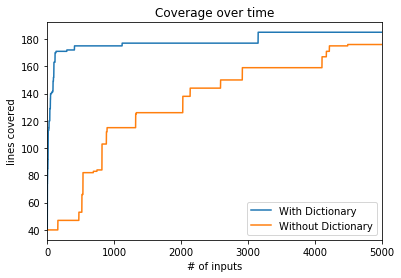

In [16]:
_, dict_cov = population_coverage(dict_fuzzer.inputs, my_parser)
_, fuzz_cov = population_coverage(fuzzer.inputs, my_parser)
line_dict, = plt.plot(dict_cov, label="With Dictionary")
line_fuzz, = plt.plot(fuzz_cov, label="Without Dictionary")
plt.legend(handles=[line_dict, line_fuzz])
plt.xlim(0,n)
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

<!-- \todo{Andreas: Section on mining keywords using parser-directed fuzzing or AUTOGRAM?} -->

***Summary.*** Informing the fuzzer about important keywords already goes a long way towards achieving lots of coverage quickly.

***Try it.*** Open this chapter as Jupyter notebook and add other HTML-related keywords to the dictionary in order to see whether the difference in coverage actually increases (given the same budget of 5k generated test inputs).

***Read up.*** Michał Zalewski, author of AFL, wrote several great blog posts on [making up grammars with a dictionary in hand](https://lcamtuf.blogspot.com/2015/01/afl-fuzz-making-up-grammar-with.html) and [pulling JPEGs out of thin air](https://lcamtuf.blogspot.com/2014/11/pulling-jpegs-out-of-thin-air.html)!

## Fuzzing with Input Fragments

While dictionaries are helpful to inject important keywords into seed inputs, they do not allow to maintain the structural integrity of the generated inputs. Instead, we need to make the fuzzer aware of the _input structure_. We can do this using [grammars](Grammars.ipynb). Our first approach 

1. [parses](Parser.ipynb) the seed inputs, 
2. disassembles them into input fragments, and 
3. generates new files by reassembling these fragments according to the rules of the grammar.

This combination of _parsing_ and _fuzzing_ can be very powerful, as we will see in an instant

### Parsing and Recombining JavaScript, or How to Make 50,000 USD in Four Weeks

In "Fuzzing with Code Fragments" \cite{Holler2012}, Holler, Herzig, and Zeller apply these steps to fuzz a JavaScript interpreter.  They use a JavaScript grammar to

1. _parse_ (valid) JavaScript inputs into parse trees,
2. _disassemble_ them into fragments (subtrees),
3. _recombine_ these fragments into valid JavaScript programs again, and
4. _feed_ these programs into a JavaScript interpreter for execution.

As in most fuzzing scenarios, the aim is to cause the JavaScript interpreter to crash.  Here is an example of LangFuzz-generated JavaScript code (from \cite{Holler2012}) that caused a crash in the Mozilla JavaScript interpreter:

```javascript
var haystack = "foo";
var re_text = "^foo";
haystack += "x";
re_text += "(x)";
var re = new RegExp(re_text);
re.test(haystack);
RegExp.input = Number();
print(RegExp.$1);
```

From a crash of the JavaScript interpreter, it is frequently possible to construct an *exploit* that will not only crash the interpreter, but instead have it execute code under the attacker's control.  Therefore, such crashes are serious flaws, which is why you get a bug bounty if you report them.

In the first four weeks of running his _LangFuzz_ tool, Christian Holler, first author of that paper, netted _more than USD 50,000 in bug bounties_.  To date, LangFuzz has found more than 2,600 bugs in the JavaScript browsers of Mozilla Firefox, Google Chrome, and Microsoft Edge.  If you use any of these browsers (say, on your Android phone), the combination of parsing and fuzzing has contributed significantly in making your browsing session secure.

(Note that these are the same Holler and Zeller who are co-authors of this book.  If you ever wondered why we devote a couple of chapters on grammar-based fuzzing, that's because we have had some great experience with it.)

### Parsing and Recombining HTML

In this book, let us stay with HTML input for a while.  To generate valid HTML inputs for our Python `HTMLParser`, we should first define a simple grammar. It allows to define HTML tags with attributes. Our context-free grammar does not require that opening and closing tags must match. However, we will see that such context-sensitive features can be maintained in the derived input fragments, and thus in the generated inputs.

In [17]:
import string

In [18]:
from Grammars import is_valid_grammar, srange

In [19]:
XML_TOKENS = {"<id>","<text>"}

XML_GRAMMAR = {
    "<start>": ["<xml-tree>"],
    "<xml-tree>": ["<text>",
                   "<xml-open-tag><xml-tree><xml-close-tag>", 
                   "<xml-openclose-tag>", 
                   "<xml-tree><xml-tree>"],
    "<xml-open-tag>":      ["<<id>>", "<<id> <xml-attribute>>"],
    "<xml-openclose-tag>": ["<<id>/>", "<<id> <xml-attribute>/>"],
    "<xml-close-tag>":     ["</<id>>"],
    "<xml-attribute>" :    ["<id>=<id>", "<xml-attribute> <xml-attribute>"],
    "<id>":                ["<letter>", "<id><letter>"],
    "<text>" :             ["<text><letter_space>","<letter_space>"],
    "<letter>":            srange(string.ascii_letters + string.digits +"\""+"'"+"."),
    "<letter_space>":      srange(string.ascii_letters + string.digits +"\""+"'"+" "+"\t"),
}

In [20]:
assert is_valid_grammar(XML_GRAMMAR)

In order to parse an input into a derivation tree, we use the [Earley parser](Parser.ipynb#Parsing-Context-Free-Grammars).

In [21]:
from Parser import EarleyParser
from GrammarFuzzer import display_tree

Let's run the parser on a simple HTML input and display all possible parse trees. A *parse tree* represents the input structure according to the given grammar.

In [22]:
parser = EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS)

for tree in parser.parse("<html>Text</html>"):
    display_tree(tree)

As we can see, the input starts with an opening tag, contains some text, and ends with a closing tag. Excellent. This is a structure that we can work with.

### Building the Fragment Pool
We are now ready to implement our first input-structure-aware mutator. Let's initialize the mutator with the dictionary `fragments` representing the empty fragment pool. It contains a key for each symbol in the grammar (and the empty set as value).

In [23]:
class FragmentMutator(Mutator):
    def __init__(self, parser):
        """Initialize empty fragment pool and add parser"""
        self.parser = parser
        self.fragments = {k: [] for k in self.parser.cgrammar}
        super().__init__()

The `FragmentMutator` adds fragments recursively. A *fragment* is a subtree in the parse tree and consists of the symbol of the current node and child nodes (i.e., descendant fragments). We can exclude fragments starting with symbols that are tokens, terminals, or not part of the grammar.

In [24]:
from Parser import terminals

In [25]:
class FragmentMutator(FragmentMutator):
    def add_fragment(self, fragment):
        """Recursively adds fragments to the fragment pool"""
        (symbol, children) = fragment
        if not self.is_excluded(symbol):
            self.fragments[symbol].append(fragment)
            for subfragment in children:
                self.add_fragment(subfragment)
        
    def is_excluded(self, symbol):
        """Returns true if a fragment starting with a specific
           symbol and all its decendents can be excluded"""
        return ((not symbol in self.parser.grammar()) or
                symbol in self.parser.tokens or
                symbol in terminals(self.parser.grammar()))

Parsing can take a long time, particularly if there is too much ambiguity during the parsing. In order to maintain the efficiency of mutational fuzzing, we will limit the parsing time to 200ms.

In [26]:
import signal

In [27]:
class Timeout(Exception): pass
def timeout(signum, frame): 
    raise Timeout()

# Register timeout() as handler for signal 'SIGALRM'"
signal.signal(signal.SIGALRM, timeout);

The function `add_to_fragment_pool()` parses a seed (no longer than 200ms) and adds all its fragments to the fragment pool. If the parsing of the `seed` was successful, the attribute `seed.has_structure` is set to `True`. Otherwise, it is set to `False`.

<!-- \todo{Convert this to `ExpectTimeout` (or make ExpectTimeout more efficient)} -->

In [28]:
class FragmentMutator(FragmentMutator):
    def add_to_fragment_pool(self, seed):
        """Adds all fragments of a seed to the fragment pool"""
        try: # only allow quick parsing of 200ms max
            signal.setitimer(signal.ITIMER_REAL, 0.2)
            seed.structure = next(self.parser.parse(seed.data))
            signal.setitimer(signal.ITIMER_REAL, 0)
            
            self.add_fragment(seed.structure)
            seed.has_structure = True
        except (SyntaxError, Timeout):
            seed.has_structure = False
            signal.setitimer(signal.ITIMER_REAL, 0)

Let's see how `FragmentMutator` fills the fragment pool for a simple HTML seed input. We initialize mutator with the `EarleyParser` which itself is initialized with our `XML_GRAMMAR`.

In [29]:
from GrammarFuzzer import tree_to_string

In [30]:
valid_seed = Seed("<html><header><title>Hello</title></header><body>World<br/></body></html>")
fragment_mutator = FragmentMutator(EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))
fragment_mutator.add_to_fragment_pool(valid_seed)

for key in fragment_mutator.fragments:
    print(key)
    for f in fragment_mutator.fragments[key]:
        print("|-%s" % tree_to_string(f))

<start>
<xml-tree>
<xml-open-tag>
<xml-openclose-tag>
<xml-close-tag>
<xml-attribute>
<id>
<text>
<letter>
<letter_space>


For many symbols in the grammar, we have collected a number of fragments. There are several open and closing tags and several interesting fragments starting with the `xml-tree` symbol.

***Summary***. For each interesting symbol in the grammar, the `FragmentMutator` has a set of fragments. These fragments are extracted by first parsing the inputs to be mutated.

### Fragment-Based Mutation

We can use the fragments in the fragment pool to generate new inputs. Every seed that is being mutated is disassembled into fragments, and memoized – i.e., disassembled only the first time around.

In [31]:
class FragmentMutator(FragmentMutator):
    def __init__(self, parser):
        """Initialize mutators"""
        super().__init__(parser)
        self.seen_seeds = []

    def mutate(self, seed):
        """Implement structure-aware mutation. Memoize seeds."""
        if not seed in self.seen_seeds:
            self.seen_seeds.append(seed)
            self.add_to_fragment_pool(seed)
        return super().mutate(seed)

Our first structural mutation operator is `swap_fragments()`, which choses a random fragment in the given seed and substitutes it with a random fragment from the pool. We make sure that both fragments start with the same symbol. For instance, we may swap a closing tag in the seed HTML by another closing tag from the fragment pool.

In order to choose a random fragment, the mutator counts all fragments (`n_count`) below the root fragment associated with the start-symbol.

In [32]:
class FragmentMutator(FragmentMutator):
    def count_nodes(self, fragment):
        """Returns the number of nodes in the fragment"""
        symbol, children = fragment
        if self.is_excluded(symbol):
            return 0
        return 1 + sum(map(self.count_nodes, children))

In order to swap the chosen fragment – identified using the "global" variable `self.to_swap` – the seed's parse tree is traversed recursively.

In [33]:
class FragmentMutator(FragmentMutator):
    def recursive_swap(self, fragment):
        """Recursively finds the fragment to swap."""
        symbol, children = fragment
        if self.is_excluded(symbol):
            return symbol, children

        self.to_swap -= 1
        if self.to_swap == 0: 
            return random.choice(list(self.fragments[symbol]))
        return symbol, list(map(self.recursive_swap, children))

Our structural mutator chooses a random number between 2 (i.e., excluding the `start` symbol) and the total number of fragments (`n_count`) and uses the recursive swapping to generate the new fragment. The new fragment is serialized as string and returned as new seed.

In [34]:
class FragmentMutator(FragmentMutator):
    def __init__(self, parser):
        super().__init__(parser)
        self.mutators = [self.swap_fragment]
          
    def swap_fragment(self, seed):
        """Substitutes a random fragment with another with the same symbol"""
        if seed.has_structure:
            n_nodes = self.count_nodes(seed.structure)
            self.to_swap = random.randint(2, n_nodes)
            new_structure = self.recursive_swap(seed.structure)
            
            new_seed = Seed(tree_to_string(new_structure))
            new_seed.has_structure = True
            new_seed.structure = new_structure
            return new_seed
        return seed

In [35]:
valid_seed = Seed("<html><header><title>Hello</title></header><body>World<br/></body></html>")
lf_mutator = FragmentMutator(parser)
print(valid_seed)
lf_mutator.mutate(valid_seed)

<html><header><title>Hello</title></header><body>World<br/></body></html>


<html><header>World</header><body>World<br/></body></html>

As we can see, one fragment has been substituted by another. 

We can use a similar recursive traversal to *remove* a random fragment.

In [36]:
class FragmentMutator(FragmentMutator):
    def recursive_delete(self, fragment):
        """Recursively finds the fragment to delete"""
        symbol, children = fragment
        if self.is_excluded(symbol):
            return symbol, children

        self.to_delete -= 1
        if self.to_delete == 0: 
            return symbol, []
        return symbol, list(map(self.recursive_delete, children))

We should also define the corresponding structural deletion operator, as well.

In [37]:
class FragmentMutator(FragmentMutator):
    def __init__(self, parser):
        super().__init__(parser)
        self.mutators.append(self.delete_fragment)
    
    def delete_fragment(self, seed):
        """Deletes a random fragment"""
        if seed.has_structure:
            n_nodes = self.count_nodes(seed.structure)
            self.to_delete = random.randint(2, n_nodes)
            new_structure = self.recursive_delete(seed.structure)
            
            new_seed = Seed(tree_to_string(new_structure))
            new_seed.has_structure = True
            new_seed.structure = new_structure
            # do not return an empty new_seed
            if not new_seed.data: return seed
            else: return new_seed
        return seed

***Summary***. We now have all ingredients for structure-aware fuzzing. Our mutator disassembles all seeds into fragments, which are then added to the fragment pool. Our mutator swaps random fragments in a given seed with fragments of the same type. And our mutator deletes random fragments in a given seed. This allows to maintain a high degree of validity for the generated inputs w.r.t. the given grammar.

***Try it***. Try adding other structural mutation operators. How would an *add-operator* know the position in a given seed file, where it is okay to add a fragment starting with a certain symbol?

### Fragment-Based Fuzzing

We can now define a input-structure aware fuzzer as pioneered in LangFuzzer. To implement LangFuzz, we modify our [blackbox mutational fuzzer](GreyboxFuzzer.ipynb#Blackbox-Mutation-based-Fuzzer) to stack up to four structural mutations.

In [38]:
class LangFuzzer(MutationFuzzer):
    def create_candidate(self):
        """Returns an input generated by fuzzing a seed in the population"""
        candidate = self.schedule.choose(self.population)
        trials = random.randint(1,4)
        for i in range(trials):
            candidate = self.mutator.mutate(candidate)
        return candidate

Okay, let's take our first input-structure aware fuzzer for a spin. Being careful, we set n=300 for now.

In [39]:
n = 300
runner = FunctionCoverageRunner(my_parser)
mutator = FragmentMutator(EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))
schedule = PowerSchedule()

langFuzzer = LangFuzzer([valid_seed.data], mutator, schedule)

start = time.time()
langFuzzer.runs(runner, trials = n)
end = time.time()

"It took LangFuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took LangFuzzer 0.35 seconds to generate and execute 300 inputs.'

We observe that structural mutation is *sooo very slow*. This is despite our time budget of 200ms for parsing. In contrast, our blackbox fuzzer alone can generate about 10k inputs per second!

In [40]:
runner = FunctionCoverageRunner(my_parser)
mutator = Mutator()
schedule = PowerSchedule()

blackFuzzer = MutationFuzzer([valid_seed.data], mutator, schedule)

start = time.time()
blackFuzzer.runs(runner, trials = n)
end = time.time()

"It took a blackbox fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took a blackbox fuzzer 0.39 seconds to generate and execute 300 inputs.'

Indeed, our blackbox fuzzer is done in the blink of an eye.

***Try it***. We can deal with this overhead using [deferred parsing](https://arxiv.org/abs/1811.09447). Instead of wasting time in the beginning of the fuzzing campaign when a byte-level mutator would make efficient progress, deferred parsing suggests to invest time in structural mutation only later in the fuzzing campaign when it becomes viable.

In [41]:
blackbox_coverage = len(runner.coverage())
"During this fuzzing campaign, the blackbox fuzzer covered %d statements." % blackbox_coverage

'During this fuzzing campaign, the blackbox fuzzer covered 117 statements.'

Let's print some stats for our fuzzing campaigns. Since we'll need to print stats more often later, we should wrap this into a function. In order to measure coverage, we import the [population_coverage](Coverage.ipynb#Coverage-of-Basic-Fuzzing) function. It takes a set of inputs and a Python function, executes the inputs on that function and collects coverage information. Specifically, it returns a tuple `(all_coverage, cumulative_coverage)` where `all_coverage` is the set of statements covered by all inputs, and `cumulative_coverage` is the number of statements covered as the number of executed inputs increases. We are just interested in the latter to plot coverage over time.

In [42]:
from Coverage import population_coverage

In [43]:
def print_stats(fuzzer, parser):
    coverage, _ = population_coverage(fuzzer.inputs, my_parser)
    
    has_structure = 0
    for seed in fuzzer.inputs:
        # reuse memoized information
        if hasattr(seed, "has_structure"):
            if seed.has_structure: 
                has_structure += 1
        else:
            if isinstance(seed, str):
                seed = Seed(seed)
            try:
                signal.setitimer(signal.ITIMER_REAL, 0.2)
                next(parser.parse(seed.data))
                signal.setitimer(signal.ITIMER_REAL, 0)
                has_structure += 1
            except (SyntaxError, Timeout):
                signal.setitimer(signal.ITIMER_REAL, 0)
        
    print("From the %d generated inputs, %d (%0.2f%%) can be parsed.\n"
          "In total, %d statements are covered." % (
        len(fuzzer.inputs),
        has_structure,
        100 * has_structure / len(fuzzer.inputs),
        len(coverage)))

For LangFuzzer, let's see how many of the inputs generated by LangFuzz are valid (i.e., parsable) and how many statements were covered.

In [44]:
print_stats(langFuzzer, EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))

From the 300 generated inputs, 1 (0.33%) can be parsed.
In total, 92 statements are covered.


What are the stats for the mutational fuzzer that uses only byte-level mutation (and no grammars)?

In [45]:
print_stats(blackFuzzer, EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))

From the 300 generated inputs, 4 (1.33%) can be parsed.
In total, 158 statements are covered.


***Summary***. Our fragment-level blackbox fuzzer (LangFuzzer) generates *more valid inputs* but achieves *less code coverage* than a fuzzer with our byte-level fuzzer. So, there is some value in generating inputs that do not stick to the provided grammar. 

### Integration with Greybox Fuzzing

In the following we integrate fragment-level blackbox fuzzing (LangFuzz-style) with [byte-level greybox fuzzing](GreyboxFuzzer.ipynb#Greybox-Mutation-based-Fuzzer) (AFL-style). The additional coverage-feedback might allow us to increase code coverage more quickly.

A [greybox fuzzer](GreyboxFuzzer.ipynb#Greybox-Mutation-based-Fuzzer) adds to the seed population all generated inputs which increase code coverage. Inputs are generated in two stages, stacking up to four structural mutations and up to 32 byte-level mutations.

In [46]:
class GreyboxGrammarFuzzer(GreyboxFuzzer):
    def __init__(self, seeds, byte_mutator, tree_mutator, schedule):
        super().__init__(seeds, byte_mutator, schedule)
        self.tree_mutator = tree_mutator
    
    def create_candidate(self):
        """Returns an input generated by structural mutation of a seed in the population"""
        seed = self.schedule.choose(self.population)
        
        # Structural mutation
        trials = random.randint(0,4)
        for i in range(trials):
            seed = self.tree_mutator.mutate(seed)
        
        # Byte-level mutation
        candidate = seed.data
        if trials == 0 or not seed.has_structure or 1 == random.randint(0, 1):
            dumb_trials = min(len(seed.data), 1 << random.randint(1,5))
            for i in range(dumb_trials):
                candidate = self.mutator.mutate(candidate)
        return candidate

Let's run our integrated fuzzer with the [standard byte-level mutator](GreyboxFuzzer.ipynb#Mutator-and-Seed) and our [fragment-based structural mutator](#Fragment-based-Mutation) that was introduced above.

In [47]:
runner = FunctionCoverageRunner(my_parser)
byte_mutator = Mutator()
tree_mutator = FragmentMutator(EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))
schedule = PowerSchedule()

gg_fuzzer = GreyboxGrammarFuzzer([valid_seed.data], byte_mutator, tree_mutator, schedule)

start = time.time()
gg_fuzzer.runs(runner, trials = n)
end = time.time()

"It took the greybox grammar fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the greybox grammar fuzzer 1.77 seconds to generate and execute 300 inputs.'

In [48]:
print_stats(gg_fuzzer, EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))

From the 300 generated inputs, 0 (0.00%) can be parsed.
In total, 160 statements are covered.


***Summary***. Our structural greybox fuzzer 
* runs faster than the fragment-based LangFuzzer,
* achieves more coverage than both the fragment-based LangFuzzer and the vanilla blackbox mutational fuzzer, and
* generates fewer valid inputs than even the vanilla blackbox mutational fuzzer.

## Mutating Invalid Seeds

In the previous section, we have seen that most inputs that are added as seeds are *invalid* w.r.t. our given grammar. Yet, in order to apply our fragment-based mutators, we need it to parse the seed successfully. Otherwise, the entire fragment-based approach becomes useless.  The question arises: *How can we derive structure from (invalid) seeds that cannot be parsed successfully?*

To this end, we introduce the idea of _region-based mutation_, first explored with the [AFLSmart](https://github.com/aflsmart/aflsmart) structural greybox fuzzer \cite{Pham2018aflsmart}. AFLSmart implements byte-level, fragment-based, and region-based mutation as well as validity-based power schedules. We define *region-based mutators*, where a *region* is a consecutive sequence of bytes in the input that can be associated with a symbol in the grammar.

### Determining Symbol Regions
The function `chart_parse` of the [Earley parser](Parser.ipynb#The-Parsing-Algorithm) produces a parse table for a string. For each letter in the string, this table gives the potential symbol and a *region* of neighboring letters that might belong to the same symbol.

In [49]:
invalid_seed = Seed("<html><body><i>World</i><br/>>/body></html>")
parser = EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS)
table = parser.chart_parse(invalid_seed.data, parser.start_symbol())
for column in table:
    print(column)
    print("---")

None chart[0]

---
< chart[1]

---
h chart[2]
<letter>:= h |(1,2)
<id>:= <letter> |(1,2)
---
t chart[3]
<letter>:= t |(2,3)
<id>:= <id> <letter> |(1,3)
---
m chart[4]
<letter>:= m |(3,4)
<id>:= <id> <letter> |(1,4)
---
l chart[5]
<letter>:= l |(4,5)
<id>:= <id> <letter> |(1,5)
---
> chart[6]
<xml-open-tag>:= < <id> > |(0,6)
---
< chart[7]

---
b chart[8]
<letter>:= b |(7,8)
<id>:= <letter> |(7,8)
---
o chart[9]
<letter>:= o |(8,9)
<id>:= <id> <letter> |(7,9)
---
d chart[10]
<letter>:= d |(9,10)
<id>:= <id> <letter> |(7,10)
---
y chart[11]
<letter>:= y |(10,11)
<id>:= <id> <letter> |(7,11)
---
> chart[12]
<xml-open-tag>:= < <id> > |(6,12)
---
< chart[13]

---
i chart[14]
<letter>:= i |(13,14)
<id>:= <letter> |(13,14)
---
> chart[15]
<xml-open-tag>:= < <id> > |(12,15)
---
W chart[16]
<letter_space>:= W |(15,16)
<text>:= <letter_space> |(15,16)
<xml-tree>:= <text> |(15,16)
---
o chart[17]
<letter_space>:= o |(16,17)
<text>:= <text> <letter_space> |(15,17)
<text>:= <letter_space> |(16,17)


The number of columns in this table that are associated with potential symbols correspond to the number of letters that could be parsed successfully. In other words, we can use this table to compute the longest parsable substring.

In [50]:
cols = [col for col in table if col.states]
parsable = invalid_seed.data[:len(cols)-1]

print("'%s'" % invalid_seed)
parsable

'<html><body><i>World</i><br/>>/body></html>'


'<html><body><i>World</i><br/>'

From this, we can compute the *degree of validity* for an input.

In [51]:
validity = 100 * len(parsable) / len(invalid_seed.data)

"%0.1f%% of the string can be parsed successfully." % validity

'67.4% of the string can be parsed successfully.'

***Summary***. Unlike input fragments, input regions can be derived even if the parser fails to generate the entire parse tree.

### Region-based Mutation
To fuzz invalid seeds, the region-based mutator associates symbols from the grammar with regions (i.e., indexed substrings) in the seed. The [overridden](#Building-the-Fragment-Pool) method `add_to_fragment_pool()` first tries to mine the fragments from the seed. If this fails, the region mutator uses [Earley parser](Parser.ipynb#The-Parsing-Algorithm) to derive the parse table. For each column (i.e., letter), it extracts the symbols and corresponding regions. This allows the mutator to store the set of regions with each symbol.

In [52]:
class RegionMutator(FragmentMutator):
    def add_to_fragment_pool(self, seed):
        """Mark fragments and regions in a seed file"""
        super().add_to_fragment_pool(seed)
        if not seed.has_structure:
            try:
                signal.setitimer(signal.ITIMER_REAL, 0.2) # set 200ms timeout
                seed.regions = {k: set() for k in self.parser.cgrammar}
                for column in self.parser.chart_parse(seed.data, self.parser.start_symbol()):
                    for state in column.states:
                        if (not self.is_excluded(state.name) and
                                state.e_col.index - state.s_col.index > 1 and
                                state.finished()):
                            seed.regions[state.name].add((state.s_col.index, state.e_col.index))
                signal.setitimer(signal.ITIMER_REAL, 0) # cancel timeout
                seed.has_regions = True
            except Timeout:
                seed.has_regions = False
        else:
            seed.has_regions = False

This is how these regions look like for our invalid seed. A region consists of a start and end index in the seed string.

In [53]:
mutator = RegionMutator(parser)
mutator.add_to_fragment_pool(invalid_seed)
for symbol in invalid_seed.regions:
    print(symbol)
    for (s, e) in invalid_seed.regions[symbol]:
        print("|-(%d,%d) : %s" % (s, e, invalid_seed.data[s:e]))

<start>
<xml-tree>
|-(17,19) : rl
|-(18,20) : ld
|-(24,29) : <br/>
|-(15,20) : World
|-(17,20) : rld
|-(12,24) : <i>World</i>
|-(15,18) : Wor
|-(16,20) : orld
|-(12,29) : <i>World</i><br/>
|-(15,19) : Worl
|-(16,19) : orl
|-(16,18) : or
|-(15,17) : Wo
<xml-open-tag>
|-(0,6) : <html>
|-(12,15) : <i>
|-(6,12) : <body>
<xml-openclose-tag>
|-(24,29) : <br/>
<xml-close-tag>
|-(20,24) : </i>
<xml-attribute>
<id>
<text>
<letter>
<letter_space>


Now that we know which regions in the seed belong to which symbol, we can define region-based swap and delete operators.

In [54]:
class RegionMutator(RegionMutator):
    def swap_fragment(self, seed):
        """Chooses a random region and swaps it with a fragment
           that starts with the same symbol"""
        if not seed.has_structure and seed.has_regions:
            regions = [r for r in seed.regions
                         if (len(seed.regions[r]) > 0 and
                            len(self.fragments[r]) > 0)]
            if len(regions) == 0: return seed
                
            key = random.choice(list(regions))
            s, e = random.choice(list(seed.regions[key]))
            swap_structure = random.choice(self.fragments[key])
            swap_string = tree_to_string(swap_structure)
            new_seed = Seed(seed.data[:s] + swap_string + seed.data[e:])
            new_seed.has_structure = False
            new_seed.has_regions = False
            return new_seed
        else:
            return super().swap_fragment(seed)

In [55]:
class RegionMutator(RegionMutator):
    def delete_fragment(self, seed):
        """Deletes a random region"""
        if not seed.has_structure and seed.has_regions:
            regions = [r for r in seed.regions
                         if len(seed.regions[r]) > 0]
            if len(regions) == 0: return seed

            key = random.choice(list(regions))
            s, e = (0, 0)
            while (e - s < 2):
                s, e = random.choice(list(seed.regions[key]))
            new_seed = Seed(seed.data[:s] + seed.data[e:])
            new_seed.has_structure = False
            new_seed.has_regions = False
            return new_seed
        else:
            return super().delete_fragment(seed)

Let's try our new region-based mutator. We add a simple, valid seed to the fragment pool and attempt to mutate the invalid seed.

In [56]:
simple_seed = Seed("<b>Text</b>")
mutator = RegionMutator(parser)
mutator.add_to_fragment_pool(simple_seed)

print(invalid_seed)
mutator.mutate(invalid_seed)

<html><body><i>World</i><br/>>/body></html>


<html><body><i>Textd</i><br/>>/body></html>

***Summary***. We can use the Earley parser to generate a parse table and assign regions in the input to symbols in the grammar. Our region mutators can substitute these region with fragments from the fragment pool that start with the same symbol, or delete these regions entirely.

***Try it***. Implement a region pool (similar to the fragment pool) and a `swap_region()` mutator.
You can execute your own code by opening this chapter as Jupyter notebook.

### Region-Based Fuzzing

Let's try our shiny new region mutator by integrating it with our [structure-aware greybox fuzzer](#Integration-with-Greybox-Fuzzing).

In [57]:
runner = FunctionCoverageRunner(my_parser)
byte_mutator = Mutator()
tree_mutator = RegionMutator(EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))
schedule = PowerSchedule()

regionFuzzer = GreyboxGrammarFuzzer([valid_seed.data], byte_mutator, tree_mutator, schedule)

start = time.time()
regionFuzzer.runs(runner, trials = n)
end = time.time()

"It took the structural greybox fuzzer with region mutator\
 %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the structural greybox fuzzer with region mutator 7.23 seconds to generate and execute 300 inputs.'

We can see that the structural greybox fuzzer with region-based mutator is slower than the [fragment-based mutator alone](#Fragment-based-Fuzzing). This is because region-based structural mutation is applicable for *all seeds*. In contrast, fragment-based mutators were applicable only for tiny number of parsable seeds. Otherwise, only (very efficient) byte-level mutators were applied.

Let's also print the average degree of validity for the seeds in the population.

In [58]:
def print_more_stats(fuzzer, parser):
    print_stats(fuzzer, parser)
    validity = 0
    total = 0
    for seed in fuzzer.population:
        if not seed.data: continue
        table = parser.chart_parse(seed.data, parser.start_symbol())
        cols = [col for col in table if col.states]
        parsable = invalid_seed.data[:len(cols)-1]
        validity += len(parsable) / len(seed.data)
        total += 1
    print("On average, %0.1f%% of a seed in the population can be successfully parsed." % (100 * validity / total))

In [59]:
print_more_stats(regionFuzzer, parser)

From the 300 generated inputs, 0 (0.00%) can be parsed.
In total, 179 statements are covered.
On average, 9.9% of a seed in the population can be successfully parsed.


***Summary***. Compared to fragment-based mutation, a greybox fuzzer with region-based mutation achieves *higher coverage* but generates a *smaller number of valid inputs*. The higher coverage is explained by leveraging at least *some* structure for seeds that cannot be parsed successfully.


## Focusing on Valid Seeds

In the previous section, we have a problem: The low (degree of) validity.  To address this problem, a _validity-based power schedule_ assigns more [energy](GreyboxFuzzer.ipynb#Power-Schedules) to seeds that have a higher degree of validity.  In other words, the fuzzer _spends more time fuzzing seeds that are more valid_.

In [60]:
import math

In [61]:
class AFLSmartSchedule(PowerSchedule):
    
    def __init__(self, parser, exponent):
        self.parser = parser
        self.exponent = exponent
    
    def parsable(self, seed):
        """Returns the substring that is parsable"""
        table = self.parser.chart_parse(seed.data, self.parser.start_symbol())
        cols = [col for col in table if col.states]
        return seed.data[:len(cols)-1]
    
    def degree_of_validity(self, seed):
        """Returns the proportion of a seed that is parsable"""
        if hasattr(seed, "validity"): return seed.validity
        seed.validity = (len(self.parsable(seed)) / len(seed.data)
                         if len(seed.data) > 0 else 0)
        return seed.validity
    
    def assignEnergy(self, population):
        """Assign exponential energy proportional to degree of validity"""
        for seed in population:
            seed.energy = ((self.degree_of_validity(seed) / math.log(len(seed.data))) ** self.exponent
                           if len(seed.data) > 1 else 0)

Let's play with the degree of validity by passing in a valid seed ...

In [62]:
smart_schedule = AFLSmartSchedule(parser, 1)
print("%11s: %s" % ("Entire seed", simple_seed))
print("%11s: %s" % ("Parsable", smart_schedule.parsable(simple_seed)))

"Degree of validity: %0.2f%%" % (100 * smart_schedule.degree_of_validity(simple_seed))

Entire seed: <b>Text</b>
   Parsable: <b>Text</b>


'Degree of validity: 100.00%'

... and an invalid seed.

In [63]:
print("%11s: %s" % ("Entire seed", invalid_seed))
print("%11s: %s" % ("Parsable", smart_schedule.parsable(invalid_seed)))

"Degree of validity: %0.2f%%" % (100 * smart_schedule.degree_of_validity(invalid_seed))

Entire seed: <html><body><i>World</i><br/>>/body></html>
   Parsable: <html><body><i>World</i><br/>


'Degree of validity: 67.44%'

Excellent. We can compute the degree of validity as the proportion of the string that can be parsed. 

Let's plug the validity-based power schedule into the structure-aware greybox fuzzer.

In [64]:
runner = FunctionCoverageRunner(my_parser)
byte_mutator = Mutator()
tree_mutator = RegionMutator(EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))
schedule = AFLSmartSchedule(parser, 1)

aflsmart = GreyboxGrammarFuzzer([valid_seed.data], byte_mutator, tree_mutator, schedule)

start = time.time()
aflsmart.runs(runner, trials = n)
end = time.time()

"It took AFLSmart %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took AFLSmart 18.70 seconds to generate and execute 300 inputs.'

In [65]:
print_more_stats(aflsmart, parser)

From the 300 generated inputs, 5 (1.67%) can be parsed.
In total, 155 statements are covered.
On average, 19.4% of a seed in the population can be successfully parsed.


***Summary***. Indeed, by spending more time fuzzing seeds with a higher degree of validity, we also generate inputs with a higher degree of validity. More inputs are entirely valid w.r.t. the given grammar.

***Read up***. Learn more about region-based fuzzing, deferred parsing, and validity-based schedules in the original AFLSmart paper: "[Smart Greybox Fuzzing](https://arxiv.org/abs/1811.09447)" by Pham et al.. Download and improve AFLSmart: [https://github.com/aflsmart/aflsmart](https://github.com/aflsmart/aflsmart).

## Mining Seeds

By now, it should have become clear that the _choice of seeds_ can very much influence the success of fuzzing.  One aspect is _variability_ – our seeds should cover as many different features as possible in order to increase coverage.  Another aspect, however, is the _likelihood of a seed to induce errors_ – that is, if a seed was involved in causing a failure before, then a mutation of this very seed may be likely to induce failures again.  This is because fixes for past failures typically are successful in letting the concrete failure no longer occur, but sometimes may fail to capture all conditions under which a failure may occur.  Hence, even if the original failure is fixed, the likelihood of an error in the _surroundings_ of the original failure-inducing input is still higher.  It thus pays off to use as seeds _inputs that are known to have caused failures before_.

To put things in context, Holler's _LangFuzz_ fuzzer used as seeds JavaScript inputs from CVE reports.  These were published as failure-inducing inputs at a time when the error already had been fixed; thus they could do no harm anymore.  Yet, by using such inputs as seeds, LangFuzz would create plenty of mutations and recombinations of all their features, many of which would (and do) find errors again and again.

## Lessons Learned

* A **dictionary** is useful to inject important keywords into the generated inputs.

* **Fragment-based mutation** first disassembles seeds into fragments, and reassembles these fragments to generate new inputs. A *fragment* is a subtree in the seed's parse tree. However, fragment-based mutation requires that the seeds can be parsed successfully, which may not be true for seeds discovered by a coverage-based greybox fuzzer.

* **Region-based mutation** marks regions in the input as belonging to a certain symbol in the grammar. For instance, it may identify a substring '</a>' as closing tag. These regions can then be deleted or substituted by fragments or regions belonging to the same symbol. Unlike fragment-based mutation, region-based mutation is applicable to *all* seeds - even those that can be parsed only partially. However, the degree of validity is still quite low for the generated inputs.

* A **validity-based power schedule** invests more energy into seeds with a higher degree of validity. The inputs that are generated also have a higher degree of validity.

* **Mining seeds** from repositories of previous failure-inducing inputs results in input fragments associated with past failures, raising the likelihood to find more failures in the vicinity.

## Next Steps

This chapter closes our discussion of syntactic fuzzing techniques.

* In the [next chapter](Reducer.ipynb), we discuss how to _reduce failure-inducing inputs_ after a failure, keeping only those portions of the input that are necessary for reproducing the failure.
* The [next part](04_Semantical_Fuzzing.ipynb) will go from syntactical to _semantical_ fuzzing, considering code semantics for targeted test generation.

## Background

This chapter builds on the following two works:

* The _LangFuzz_ fuzzer \cite{Holler2012} is an efficient (and effective!) grammar-based fuzzer for (mostly) JavaScript.  It uses the grammar for parsing seeds and recombining their inputs with generated parts and found 2,600 bugs in JavaScript interpreters to date.

* Smart greybox fuzzing ([AFLSmart](https://github.com/aflsmart/aflsmart)) brings together coverage-based fuzzing and grammar-based (structural) fuzzing, as described in \cite{Pham2018aflsmart}.  The resulting AFLSMART tool has discovered 42 zero-day vulnerabilities in widely-used, well-tested tools and libraries; so far 17 CVEs were assigned.

Recent fuzzing work also brings together grammar-based fuzzing and coverage.

* _Superion_ \cite{Wang2019superion} is equivalent to our section "Integration with Greybox Fuzzing", as above – that is, a combination of LangFuzz and Greybox Fuzzing, but no AFL-style byte-level mutation.  Superion can improve the code coverage (i.e., 16.7% and 8.8% in line and function coverage) and bug-finding capability over AFL and jsfunfuzz.  According to the authors, they found 30 new bugs, among which they discovered 21 new vulnerabilities with 16 CVEs assigned and 3.2K USD bug bounty rewards received.

* _Nautilus_ \cite{Aschermann2019nautilus} also combines grammar-based fuzzing with coverage feedback.  It maintains the parse tree for all seeds and generated inputs. To allow AFL-style byte-level mutations, it "collapses" subtrees back to byte-level representations.  This has the advantage of not having to re-parse generated seeds; however, over time, Nautilus de-generates to structure-unaware greybox fuzzing because it does not re-parse collapsed subtrees to reconstitute input structure for later seeds where most of the parse tree is collapsed.  Nautilus identified bugs in mruby, PHP, ChakraCore, and in Lua; reporting these bugs was awarded with a sum of 2600 USD and 6 CVEs were assigned.

## Exercises


### Exercise 1: The Big Greybox Fuzzer Shoot-Out

Use our implementations of greybox techniques and evaluate them on a benchmark.  Which technique (and which sub-technique) has which impact and why?  Also take into account the specific approaches of Superion \cite{Wang2019superion} and Nautilus \cite{Aschermann2019nautilus}, possibly even on the benchmarks used by these approaches.

**Solution.**  To be added by Summer 2019.